# Spectroscopy: CCD Characterisation and master bias/flat

`author` Julien Morin <julien.morin@umontpellier.fr>

`date` 26 Jul 2022

Adapted from HAP703P

Reference: *Handbook of CCD Astronomy*, §4.3
* compute CCD gain and readout noise
* compute and save master bias
* compute and save master flat

In [1]:
# import and settings
%matplotlib notebook
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import mad_std
from astropy import units as u
from astropy.visualization import ZScaleInterval
import ccdproc as ccdp
from iraf_um import imstat, inv_median

In [2]:
# create bias image collections and print summary
print("Bias frames")
ifc_bias = ccdp.ImageFileCollection('calibration/', glob_include='Bias_*.fit*')
print(ifc_bias.summary['date', 'exposure'], '\n')
# load bias CCDData objects and reshape data to be 2-D images
# using an ImageFileCollection does not work because of the data shape (naxis=3)
ccdd_bias = [ccdp.CCDData.read(ifc_bias.location+bias_file, unit='adu') for bias_file in ifc_bias.files]
print("original bias shape:", ccdd_bias[0].data.shape)
for b in ccdd_bias:
    b.data = b.data[0]
print("new bias shape:", ccdd_bias[0].data.shape)
print("")

# same operations for flat fields
print("Flat Field frames")
ifc_flat = ccdp.ImageFileCollection('calibration/', glob_include='Flat_*.fit*')
print(ifc_flat.summary['date', 'exposure'])
#
ccdd_flat = [ccdp.CCDData.read(ifc_flat.location+flat_file, unit='adu') for flat_file in ifc_flat.files]
print("original flat shape:", ccdd_flat[0].data.shape)
for f in ccdd_flat:
    f.data = f.data[0]
print("new flat shape:", ccdd_flat[0].data.shape)


Bias frames
        date        exposure
------------------- --------
2022-09-19T19:47:40    1e-05
2022-09-19T19:47:58    1e-05
2022-09-19T19:48:04    1e-05
2022-09-19T19:48:10    1e-05
2022-09-19T19:48:15    1e-05
2022-09-19T19:48:21    1e-05
2022-09-19T19:48:26    1e-05
2022-09-19T19:48:33    1e-05
2022-09-19T19:48:39    1e-05
2022-09-19T19:48:44    1e-05
                ...      ...
2022-09-22T18:45:11    1e-05
2022-09-21T18:41:55    1e-05
2022-09-21T18:42:06    1e-05
2022-09-21T18:42:16    1e-05
2022-09-21T18:42:22    1e-05
2022-09-21T18:42:36    1e-05
2022-09-21T18:42:42    1e-05
2022-09-21T18:42:47    1e-05
2022-09-21T18:42:53    1e-05
2022-09-21T18:42:58    1e-05
2022-09-21T18:43:03    1e-05
Length = 32 rows 

original bias shape: (1, 100, 2048)
new bias shape: (100, 2048)

Flat Field frames
        date        exposure
------------------- --------
2022-09-22T18:34:25     30.0
2022-09-22T18:35:04     30.0
2022-09-22T18:35:41     30.0
2022-09-22T18:36:21     30.0
2022-09-22T18:37

## CCD gain and readout noise

In [3]:
# compute and display statistics on two bias and two flat field frames
imstat(['bias1', 'bias2', 'flat1', 'flat2'], [ccdd_bias[0], ccdd_bias[1], ccdd_flat[2], ccdd_flat[3]])

frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   bias1    204800  287.000   314.000 ...  301.000    2.931    2.965  adu
   bias2    204800  288.000   315.000 ...  302.000    2.918    2.965  adu
   flat1    204800  297.000 13228.000 ...  311.000 3181.870 2072.678  adu
   flat2    204800  298.000 13296.000 ...  308.000 3184.658 2074.161  adu


<IPython.core.display.Javascript object>


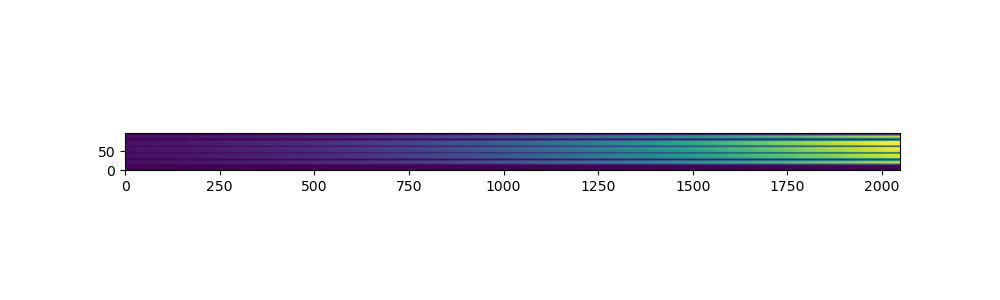

In [4]:
# Plot flat-field frames to identify illuminated area
plt.figure(figsize=(10,3))
interval = ZScaleInterval()
z1, z2 = interval.get_limits(ccdd_flat[0])
plt.imshow(ccdd_flat[0].data, origin='lower', vmin=z1, vmax=z2)
plt.show()

In [5]:
#Interpolation meilleure couple de flat

for i in range(10):
    for j in range(i):
        #Check histogram, flat + ThAr ???
        print('\nCouple',i,' and ',j)
        sumb1b2 = ccdd_bias[i].data.astype('float32') + ccdd_bias[j].data.astype('float32')
        diffb1b2 = ccdd_bias[i].data.astype('float32') - ccdd_bias[j].data.astype('float32')
        sumf1f2 = ccdd_flat[i].data.astype('float32') + ccdd_flat[j].data.astype('float32')
        difff1f2 = ccdd_flat[i].data.astype('float32') - ccdd_flat[j].data.astype('float32')
        
        imstat(['b1+b2', 'b1-b2', 'f1+f2', 'f1-f2'], [sumb1b2, diffb1b2, sumf1f2, difff1f2])
        
        ccd_gain = (np.mean(sumf1f2) - np.mean(sumb1b2)) / (np.var(difff1f2) - np.var(diffb1b2)) * u.electron / u.adu
        print('CCD Gain = ', ccd_gain)
        ccd_ron = ccd_gain * np.std(diffb1b2) / np.sqrt(2.) * u.adu
        print('CCD RON = ', ccd_ron)


Couple 1  and  0
frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  582.000   620.000 ...  598.000    4.142    4.448 None
   b1-b2    204800  -20.000    19.000 ...    0.000    4.130    4.448 None
   f1+f2    204800  606.000 26843.000 ...  640.000 6433.304 4203.177 None
   f1-f2    204800 -722.000   478.000 ...   -8.000   95.887   54.856 None
CCD Gain =  0.6320707201957703 electron / adu
CCD RON =  1.8460715828147587 electron

Couple 2  and  0
frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  581.000   621.000 ...  599.000    4.159    4.448 None
   b1-b2    204800  -18.000    21.000 ...   -1.000    4.134    4.448 None
   f1+f2    204800  605.000 26632.000 ...  626.000 6425.988 4194.282 None
   f1-f2    204800 -779.000   396.000 ...   -3.000  101.125   57.

frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  584.000   622.000 ...  600.000    4.152    4.448 None
   b1-b2    204800  -18.000    19.000 ...   -2.000    4.141    4.448 None
   f1+f2    204800  606.000 26729.000 ...  644.000 6440.279 4200.212 None
   f1-f2    204800 -839.000   635.000 ...   -6.000  114.377   63.752 None
CCD Gain =  0.4443264603614807 electron / adu
CCD RON =  1.3010576191973497 electron

Couple 6  and  1
frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  582.000   620.000 ...  602.000    4.138    4.448 None
   b1-b2    204800  -18.000    19.000 ...   -4.000    4.138    4.448 None
   f1+f2    204800  603.000 26511.000 ...  638.000 6384.930 4158.699 None
   f1-f2    204800 -662.000   709.000 ...   -6.000   98.138   54.856 None
CCD Gain 

CCD Gain =  0.4035738706588745 electron / adu
CCD RON =  1.1844276798862454 electron

Couple 8  and  3
frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  584.000   619.000 ...  599.000    4.125    4.448 None
   b1-b2    204800  -19.000    20.000 ...    0.000    4.150    4.448 None
   f1+f2    204800  605.000 26550.000 ... 1711.000 6386.830 4154.251 None
   f1-f2    204800 -756.000   840.000 ...   -4.000  111.071   59.304 None
CCD Gain =  0.4670008718967438 electron / adu
CCD RON =  1.3702502689850784 electron

Couple 8  and  4
frame id    npix      min       max    ...   mode     std      mad    unit
-------- --------- --------- --------- ... -------- -------- -------- ----
   b1+b2    204800   582.000   619.000 ...  599.000    4.144    4.448 None
   b1-b2    204800   -16.000    20.000 ...    2.000    4.129    4.448 None
   f1+f2    204800   605.000 26590.000 ...  630.00

In [6]:
# Compute sums and differences of bias abd flat frames and print statistics
sumb1b2 = ccdd_bias[0].data.astype('float32') + ccdd_bias[1].data.astype('float32')
diffb1b2 = ccdd_bias[0].data.astype('float32') - ccdd_bias[1].data.astype('float32')
sumf1f2 = ccdd_flat[2].data.astype('float32') + ccdd_flat[1].data.astype('float32')
difff1f2 = ccdd_flat[2].data.astype('float32') - ccdd_flat[1].data.astype('float32')
imstat(['b1+b2', 'b1-b2', 'f1+f2', 'f1-f2'], [sumb1b2, diffb1b2, sumf1f2, difff1f2])

frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  582.000   620.000 ...  598.000    4.142    4.448 None
   b1-b2    204800  -19.000    20.000 ...    0.000    4.130    4.448 None
   f1+f2    204800  602.000 26439.000 ...  619.000 6370.568 4154.251 None
   f1-f2    204800 -637.000   571.000 ...   -1.000   78.056   45.961 None


In [7]:
# Compute gain and readout noise
ccd_gain = (np.mean(sumf1f2) - np.mean(sumb1b2)) / (np.var(difff1f2) - np.var(diffb1b2)) * u.electron / u.adu
print('CCD Gain = ', ccd_gain)
ccd_ron = ccd_gain * np.std(diffb1b2) / np.sqrt(2.) * u.adu
print('CCD RON = ', ccd_ron)

CCD Gain =  0.9450262188911438 electron / adu
CCD RON =  2.760111972344458 electron


À comparer aux spécifications données sur l'espace moodle HAP905P : __[https://moodle.umontpellier.fr/mod/book/view.php?id=5461&chapterid=234](https://moodle.umontpellier.fr/mod/book/view.php?id=5461&chapterid=234)__

## Master bias

In [8]:
# compute master bias
master_bias = ccdp.combine(ccdd_bias, unit='adu', combine='average', 
    sigma_clip=True, sigma_clip_low_thresh=7., sigma_clip_high_thresh=7., sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
    mem_limit=512.e6)

In [9]:
# set header keyword (will appear in the saved file)
master_bias.meta['COMBINED'] = True

In [10]:
# compare statiscal properties of the series and the master frame
imstat(ifc_bias.files, ccdd_bias)
print('\n')
imstat('master bias', master_bias)

                   frame id                       npix   ...   mad    unit
---------------------------------------------- --------- ... -------- ----
Bias_M2_ML_Mon Sep 19 2022_19.47.45_00001.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.03_00002.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.09_00003.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.15_00004.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.20_00005.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.25_00006.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.31_00007.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.38_00008.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.44_00009.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.49_00010.fits    204800 ...    2.965  adu
                                           ...       ... ...      ...  ...
Bias_M2_ML_Thu Sep 22 202

C:\Users\adria\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\adria\anaconda3\lib\site-packages\numpy\lib\function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


In [11]:
# display 1st bias, master bias and residual
fig = plt.figure(figsize=(10,9))
#
ax1 = fig.add_subplot(311)
interval1 = ZScaleInterval()
z1, z2 = interval1.get_limits(ccdd_bias[0])
im1 = ax1.imshow(ccdd_bias[0].data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im1)
ax1.set_title(ifc_bias.files[0])
#
ax2 = fig.add_subplot(312)
im2 = ax2.imshow(master_bias.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im2)
ax2.set_title('master bias')
#
ax3 = fig.add_subplot(313)
res_bias = ccdd_bias[0].data - master_bias.data
interval2 = ZScaleInterval()
z1, z2 = interval2.get_limits(res_bias)
im3 = ax3.imshow(res_bias, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im3)
ax3.set_title('bias residual')
plt.show()

<IPython.core.display.Javascript object>

In [12]:
# once master bias is fine-tuned save it
master_bias.write('reference/master_bias.fits', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

## Master Flat

In [13]:
# bias subtract the flat-field images and save them in the tmp directory
for ccd, fname in zip(ccdd_flat, ifc_flat.files):
    ccd = ccdp.subtract_bias(ccd, master_bias)
    fname_tmp = os.path.splitext(fname)[0] + '_b' + os.path.splitext(fname)[1]
    ccd.write('tmp' +'/' + fname_tmp)

OSError: File tmp/Flat_M2_ML_Thu Sep 22 2022_18.35.00_00001_b.fits already exists. If you mean to replace it then use the argument "overwrite=True".

In [14]:
# check statistics of bias-subtracted files
imstat(ifc_flat.files, ccdd_flat)
print('\n')
ifc_flat_b = ccdp.ImageFileCollection('tmp/', glob_include='Flat_*.fit*')
# the bias-corrected flat fields have the right shape (naxis=2) by construction
print(ifc_flat_b.location+ifc_flat_b.files[0], " shape: ", ccdp.CCDData.read(ifc_flat_b.location+ifc_flat_b.files[0]).data.shape, "\n")
#imstat(ifc_flat_b.files, ifc_flat_b.data())
# create a CCDData list to exclude the two flats w/ differents stats
ccdd_flat_b = [ccdp.CCDData.read(ifc_flat_b.location+flat_file) for flat_file in ifc_flat_b.files][2:]
fname_flat_b = ifc_flat_b.files[2:]
#imstat(fname_flat_b, ccdd_flat_b)

                   frame id                       npix   ...   mad    unit
---------------------------------------------- --------- ... -------- ----
Flat_M2_ML_Thu Sep 22 2022_18.35.00_00001.fits    204800 ... 2122.345  adu
Flat_M2_ML_Thu Sep 22 2022_18.35.39_00002.fits    204800 ... 2080.091  adu
Flat_M2_ML_Thu Sep 22 2022_18.36.16_00003.fits    204800 ... 2072.678  adu
Flat_M2_ML_Thu Sep 22 2022_18.36.56_00004.fits    204800 ... 2074.161  adu
Flat_M2_ML_Thu Sep 22 2022_18.37.39_00005.fits    204800 ... 2074.161  adu
Flat_M2_ML_Thu Sep 22 2022_18.38.18_00006.fits    204800 ... 2077.126  adu
Flat_M2_ML_Thu Sep 22 2022_18.39.01_00007.fits    204800 ... 2080.091  adu
Flat_M2_ML_Thu Sep 22 2022_18.39.55_00008.fits    204800 ... 2080.091  adu
Flat_M2_ML_Thu Sep 22 2022_18.40.38_00009.fits    204800 ... 2080.091  adu
Flat_M2_ML_Thu Sep 22 2022_18.41.16_00010.fits    204800 ... 2083.056  adu


tmp/Flat_M2_ML_Thu Sep 22 2022_18.35.00_00001_b.fits  shape:  (100, 2048) 



In [15]:
# compute master flat with scaling/normalisation excluding the two flats w/ different stats
master_flat = ccdp.combine(ccdd_flat_b, unit='adu', method='average', scale=inv_median, gain=ccd_gain, readnoise=ccd_ron, sigma_clip=True, sigma_clip_low_thresh=5., sigma_clip_high_thresh=5., sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, mem_limit=512.e6)

In [16]:
# set header keyword (will appear in the saved file)
master_flat.meta['COMBINED'] = True

In [17]:
# print statiscal properties of master frame
imstat('master flat', master_flat)

  frame id     npix     min      max    ...   mode     std      mad    unit
----------- --------- -------- -------- ... -------- -------- -------- ----
master flat    204800    0.004    8.561 ...    0.004    2.122    1.380  adu


C:\Users\adria\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\adria\anaconda3\lib\site-packages\numpy\lib\function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


<IPython.core.display.Javascript object>


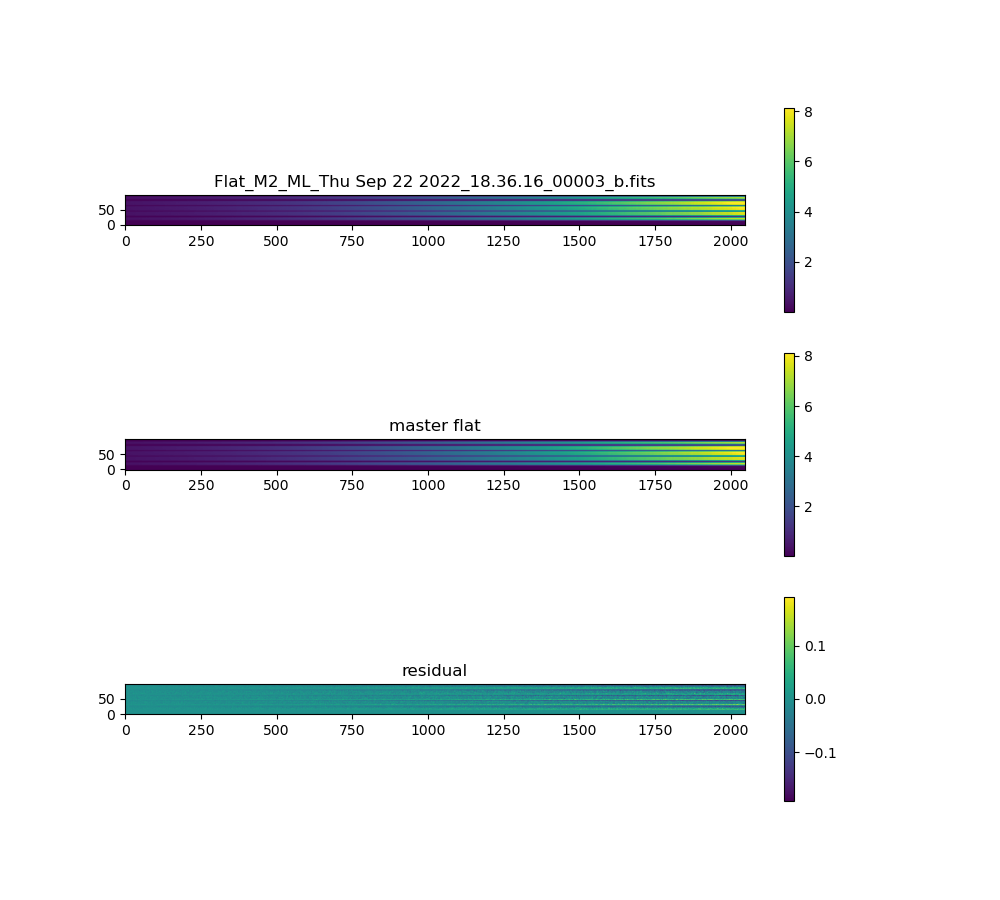

In [18]:
# display 1st scaled flat, master flat and residual
fig = plt.figure(figsize=(10,9))
#
ax1 = fig.add_subplot(311)
ccd_flat1_n = ccdd_flat_b[0] / np.median(ccdd_flat_b[0].data)
interval1 = ZScaleInterval()
z1, z2 = interval1.get_limits(ccd_flat1_n)
im1 = ax1.imshow(ccd_flat1_n.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im1)
ax1.set_title(fname_flat_b[0])
#
ax2 = fig.add_subplot(312)
im2 = ax2.imshow(master_flat.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im2)
ax2.set_title('master flat')
#
ax3 = fig.add_subplot(313)
res_flat = ccd_flat1_n.data - master_flat.data
interval2 = ZScaleInterval()
z1, z2 = interval2.get_limits(res_flat)
im3 = ax3.imshow(res_flat, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im3)
ax3.set_title('residual')
plt.show()

In [19]:
# print statistics of the residual image
imstat('flat residual', res_flat, fmt='.3e')

   frame id      npix      min        max    ...    std       mad    unit
------------- --------- ---------- --------- ... --------- --------- ----
flat residual    204800 -3.914e-01 3.392e-01 ... 4.711e-02 2.561e-02 None


In [20]:
# save master flat
master_flat.write('reference/master_flat.fits', overwrite=True)

## Clean temporary files

In [21]:
# remove all FITS files from the tmp directory
fileList = glob.glob('tmp/*.fit*')
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.36.16_00003_b.fits
Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.36.56_00004_b.fits
Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.37.39_00005_b.fits
Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.38.18_00006_b.fits
Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.39.01_00007_b.fits
Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.39.55_00008_b.fits
Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.40.38_00009_b.fits
Error while deleting file :  tmp\Flat_M2_ML_Thu Sep 22 2022_18.41.16_00010_b.fits
